In [2]:
# prompt: open "/content/drive/MyDrive/Dataset/20180108T184332_dmi_prep.nc" file using xarray
import xarray as xr
scene1 = xr.open_dataset('E:/Sepideh/data/Ready-To-Train AI4Arctic Sea Ice Challenge Dataset/20180814T120158_cis_prep.nc')
scene2 = xr.open_dataset('E:/Sepideh/data/Ready-To-Train AI4Arctic Sea Ice Challenge Dataset/20180907T120159_cis_prep.nc')

### Normalization

In [35]:
def coord_normalize(coords, extent = (-180, 180, -90, 90), do_global = False):
    """
    Given a list of coords (X, Y), normalize them to [-1, 1]
    Args:
        coords: a python list with shape (batch_size, num_context_pt, coord_dim)
        extent: (x_min, x_max, y_min, y_max)
        do_global:  True - lon/180 and lat/90
                    False - min-max normalize based on extent
    Return:
        coords_mat: np tensor shape (batch_size, num_context_pt, coord_dim)
    """
    print(extent)
    print(coords)
    if type(coords) == list:
        coords_mat = np.asarray(coords).astype(np.float32)
    elif type(coords) == np.ndarray:
        coords_mat = coords
    
    if do_global:
        coords_mat[:,:,0] /= 180.0
        coords_mat[:,:,1] /= 90.0
    else:
        # x => [0,1]  min_max normalize
        print('extent_0',extent[0])
        print('extent_1',extent[1])
        x = (coords_mat[:,:,0] - extent[0])*1.0/(extent[1] - extent[0])
        # x => [-1,1]
        coords_mat[:,:,0] = (x * 2) - 1

        # y => [0,1]  min_max normalize
        y = (coords_mat[:,:,1] - extent[2])*1.0/(extent[3] - extent[2])
        # x => [-1,1]
        coords_mat[:,:,1] = (y * 2) - 1


    return coords_mat

In [116]:
flattened_lat = scene['sar_grid2d_latitude'].values.flatten()
flattened_lon = scene['sar_grid2d_longitude'].values.flatten()
type(flattened_lat) 
flattened_lat.shape
flattened_lat[0:10]

array([0.67114325, 0.67167501, 0.67219497, 0.67270323, 0.67319986,
       0.67368488, 0.67415831, 0.67462014, 0.67507038, 0.675509  ])

In [79]:
pairs = list(zip(flattened_lon, flattened_lat))
pairs = [list(pair) for pair in pairs]

In [80]:
pairs_matrix_1 = torch.tensor(pairs).view(126, 2)
pairs_matrix_ll = torch.tensor(pairs).view(126, 2)


In [81]:
type(pairs_matrix_1)

torch.Tensor

In [82]:
pairs_matrix_1.shape

torch.Size([126, 2])

In [83]:
pairs_matrix_1 = pairs_matrix_1.unsqueeze(0).detach().numpy()
pairs_matrix_ll=pairs_matrix_ll.detach().numpy()

In [67]:
type(pairs_matrix_1)

numpy.ndarray

In [68]:
pairs_matrix_1[:0:5].shape

(0, 126, 2)

In [69]:
pairs_matrix_1[0,0:5,:]

array([[-0.25149378,  0.67114325],
       [-0.24945525,  0.67167501],
       [-0.24741298,  0.67219497],
       [-0.2453666 ,  0.67270323],
       [-0.24331588,  0.67319986]])

In [45]:
coord_normalize(pairs_matrix_1[:,0:2,:],do_global = False)

(-180, 180, -90, 90)
[[[-45.26888039  60.4028925 ]
  [-44.90194563  60.45075061]]]
extent_0 -180
extent_1 180


array([[[-0.25149378,  0.67114325],
        [-0.24945525,  0.67167501]]])

### Embedding

In [117]:
lat = scene['sar_grid2d_latitude'].values
lon = scene['sar_grid2d_longitude'].values

In [101]:
import numpy as np
import torch
import json
import os
import math
from torch.utils.data.sampler import Sampler

#https://blog.csdn.net/weixin_39627422/article/details/120463418
#https://python.hotexamples.com/examples/utils/-/encode_loc_time/python-encode_loc_time-function-examples.html
#https://blog.csdn.net/weixin_39627422/article/details/120463418
#Read code: geo_prior(2)

def encode_loc_time(loc_ip, date_ip, concat_dim=1, params=None):
    # loc is N x 2 vector, where each row is [lon,lat] entry
    # assumes inputs location and date features are in range -1 to 1
    # location is lon, lat

    if params['loc_encode'] == 'encode_cos_sin':
        feats = torch.cat((torch.sin(math.pi*loc_ip), torch.cos(math.pi*loc_ip)), concat_dim)

    elif params['loc_encode'] == 'encode_3D':
        # X, Y, Z in 3D space
        if concat_dim == 1:
            cos_lon = torch.cos(math.pi*loc_ip[:, 0]).unsqueeze(-1)
            sin_lon = torch.sin(math.pi*loc_ip[:, 0]).unsqueeze(-1)
            cos_lat = torch.cos(math.pi*loc_ip[:, 1]).unsqueeze(-1)
            sin_lat = torch.sin(math.pi*loc_ip[:, 1]).unsqueeze(-1)
        if concat_dim == 2:
            cos_lon = torch.cos(math.pi*loc_ip[:, :, 0]).unsqueeze(-1)
            sin_lon = torch.sin(math.pi*loc_ip[:, :, 0]).unsqueeze(-1)
            cos_lat = torch.cos(math.pi*loc_ip[:, :, 1]).unsqueeze(-1)
            sin_lat = torch.sin(math.pi*loc_ip[:, :, 1]).unsqueeze(-1)
        feats = torch.cat((cos_lon*cos_lat, sin_lon*cos_lat, sin_lat), concat_dim)

    elif params['loc_encode'] == 'encode_none':
        feats = loc_ip

    else:
        print('error - no loc feat type defined')

    if params['use_date_feats']:
        if params['date_encode'] == 'encode_cos_sin':
            feats_date = torch.cat((torch.sin(math.pi*date_ip.unsqueeze(-1)),
                                    torch.cos(math.pi*date_ip.unsqueeze(-1))), concat_dim)
        elif params['date_encode'] == 'encode_none':
            feats_date = date_ip.unsqueeze(-1)
        else:
            print('error - no date feat type defined')
        feats = torch.cat((feats, feats_date), concat_dim)
    else:
        feats = feats

    return feats

In [119]:
print(nlon.shape,nlat.shape)
flattened_lat = nlat.values.flatten()
flattened_lon = nlon.values.flatten()
type(flattened_lat) 
flattened_lat.shape
flattened_lat[0:10]
plonlat = list(zip(flattened_lon, flattened_lat))
plonlat = [list(plonlat) for plonlat in plonlat]
plonlat[0:10]
pairs_ll = torch.tensor(plonlat).view(126, 2)


(6, 21) (6, 21)
torch.Size([126, 2])


In [121]:
print(pairs_ll.shape)

torch.Size([126, 2])


In [113]:
scene['sar_grid2d_latitude'][0:2,:].values

array([[0.67114325, 0.67167501, 0.67219497, 0.67270323, 0.67319986,
        0.67368488, 0.67415831, 0.67462014, 0.67507038, 0.675509  ,
        0.67593598, 0.6763513 , 0.67675492, 0.67714682, 0.67752697,
        0.67789534, 0.67825189, 0.6785966 , 0.67892942, 0.67925034,
        0.67955293],
       [0.67310878, 0.67364415, 0.67416732, 0.67467845, 0.67517766,
        0.67566502, 0.67614057, 0.67660434, 0.67705632, 0.67749653,
        0.67792494, 0.67834155, 0.67874632, 0.67913925, 0.67952029,
        0.67988944, 0.68024665, 0.68059189, 0.68092515, 0.68124638,
        0.68154921]])

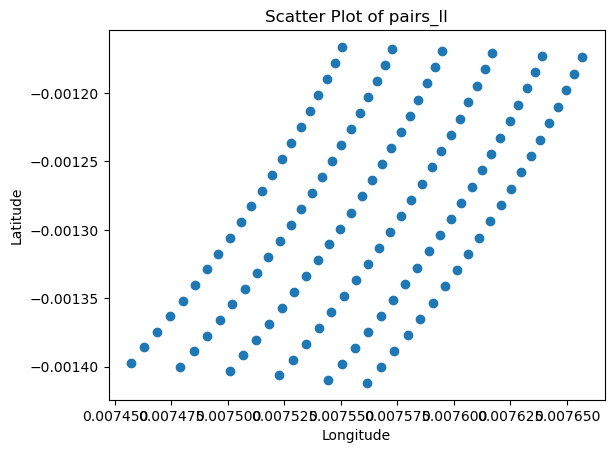

In [123]:
import matplotlib.pyplot as plt

plt.scatter(pairs_ll[:, 0], pairs_ll[:, 1])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot of pairs_ll')
plt.show()


In [103]:
enc=encode_loc_time(pairs_ll, date_ip=None, concat_dim=1, params={'loc_encode': 'encode_cos_sin', 'use_date_feats': None})

In [105]:
enc.shape

torch.Size([126, 4])

In [110]:
print(math.sin(math.pi*0.6711), math.sin(math.pi*-0.2515), math.cos(math.pi*0.6711), math.cos(math.pi*-0.2515))

0.8589777700751592 -0.7104310798498135 -0.5120128812019351 0.7037667801078906


In [106]:
enc[0:2,]

tensor([[ 0.8589, -0.7104, -0.5121,  0.7038],
        [ 0.8581, -0.7059, -0.5136,  0.7083]], dtype=torch.float64)

In [ ]:
print(math.sin(math.pi*0.6711), math.sin(math.pi*-0.2515), math.cos(math.pi*0.6711), math.cos(math.pi*-0.2515))

In [74]:

scene['SIC'].dims

('sar_lines', 'sar_samples')

In [93]:
import numpy as np
import math

def location_encode(scene):
    dims = scene['SIC'].dims
    scene['sar_grid2d_longitude_c1'] = (dims, np.sin(np.pi * scene['sar_grid2d_longitude'].values))
    scene['sar_grid2d_longitude_c2'] = (dims,np.cos(np.pi * scene['sar_grid2d_longitude'].values))
    scene['sar_grid2d_latitude_c1'] = (dims,np.sin(np.pi * scene['sar_grid2d_latitude'].values))
    scene['sar_grid2d_latitude_c2'] = (dims,np.cos(np.pi * scene['sar_grid2d_latitude'].values))
    return scene


In [62]:
import torch.nn.functional as F
def resize_latlon(scene, variable_names, size):
        new_height, new_width = size
        for variable_name in variable_names:
            # Extract the variable image you want to resize
            image = scene[variable_name].values

            # Convert the image to a PyTorch tensor
            tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0)

            # Resize the image using the interpolate function with nearest interpolation
            resized_tensor = F.interpolate(tensor, size=(new_height, new_width), mode='nearest')

            # Convert the resized tensor back to a numpy array
            resized_image = resized_tensor.squeeze().numpy()

            # Update the original netCDF file with the resized image
            scene[variable_name] = (('sar_lines', 'sar_samples'), resized_image)
            
        return scene

In [96]:
scene = resize_latlon(scene, train_options['full_variables'][6:8], scene['SIC'].shape)

In [97]:
scene['sar_grid2d_longitude'].shape

(1200, 5185)

In [99]:
location_encode(scene)

<xarray.Dataset>
Dimensions:                  (sar_lines: 1200, sar_samples: 5185,
                              2km_grid_lines: 48, 2km_grid_samples: 207)
Dimensions without coordinates: sar_lines, sar_samples, 2km_grid_lines,
                                2km_grid_samples
Data variables: (12/33)
    SIC                      (sar_lines, sar_samples) uint8 ...
    SOD                      (sar_lines, sar_samples) uint8 ...
    FLOE                     (sar_lines, sar_samples) uint8 ...
    sar_grid2d_latitude      (sar_lines, sar_samples) float64 60.4 ... 62.02
    sar_grid2d_longitude     (sar_lines, sar_samples) float64 -45.27 ... -38.04
    nersc_sar_primary        (sar_lines, sar_samples) float32 ...
    ...                       ...
    tcwv                     (2km_grid_lines, 2km_grid_samples) float32 ...
    tclw                     (2km_grid_lines, 2km_grid_samples) float32 ...
    sar_grid2d_longitude_c1  (sar_lines, sar_samples) float64 0.7478 ... -0.1133
    sar_grid2d_longitude_c2  (sar_lines, sar_samples) float64 -0.6639 ... 0.9936
    sar_grid2d_latitude_c1   (sar_lines, sar_samples) float64 0.9538 ... 0.05956
    sar_grid2d_latitude_c2   (sar_lines, sar_samples) float64 0.3004 ... 0.9982
Attributes:
    scene_id:       20180213T202018_dmi_prep.nc
    original_id:    S1A_EW_GRDM_1SDH_20180213T202018_20180213T202033_020593_0...
    ice_service:    dmi
    flip:           0
    pixel_spacing:  80

### SIngle code for normalization and encoding

In [149]:
scene['sar_grid2d_longitude'].values

array([[-0.25149378, -0.24945525, -0.24741298, -0.2453666 , -0.24331588,
        -0.24126067, -0.23920089, -0.23713649, -0.23506747, -0.23299384,
        -0.23091564, -0.22883292, -0.22674576, -0.22465423, -0.22255841,
        -0.22045839, -0.21835428, -0.21624617, -0.21413419, -0.21201843,
        -0.20994399],
       [-0.25203317, -0.24997749, -0.24791896, -0.24585702, -0.24379126,
        -0.24172144, -0.23964737, -0.23756895, -0.23548612, -0.23339885,
        -0.23130714, -0.22921104, -0.22711057, -0.22500579, -0.22289679,
        -0.22078364, -0.21866643, -0.21654525, -0.21442021, -0.21229142,
        -0.21020423],
       [-0.25257897, -0.2505091 , -0.2484368 , -0.24636141, -0.24428245,
        -0.24219959, -0.24011263, -0.23802141, -0.23592585, -0.2338259 ,
        -0.23172156, -0.22961283, -0.22749974, -0.22538236, -0.22326075,
        -0.22113497, -0.21900512, -0.2168713 , -0.21473359, -0.21259211,
        -0.21049248],
       [-0.25313115, -0.25104902, -0.24896459, -0.24687713

In [147]:
def lonlat_normalize(scene, extent = (-180, 180, -90, 90), do_global = False):
    """
    Given the ndarrays of lon and lat normalize them to [-1, 1]
    Args:
        extent: (x_min, x_max, y_min, y_max)
        do_global:  True - lon/180 and lat/90
                    False - min-max normalize based on extent
    Return:
        lon and lat normalized to [-1, 1]
    """

    if do_global:
        scene['sar_grid2d_longitude'] /= 180.0
        
        scene['sar_grid2d_latitude'] /= 90.0
    else:
        # x => [0,1]  min_max normalize
        print('extent_0',extent[0])
        print('extent_1',extent[1])
        x = (scene['sar_grid2d_longitude'] - extent[0])*1.0/(extent[1] - extent[0])
        # x => [-1,1]
        scene['sar_grid2d_longitude'] = (x * 2) - 1
        # y => [0,1]  min_max normalize
        y = (scene['sar_grid2d_latitude'] - extent[2])*1.0/(extent[3] - extent[2])
        # x => [-1,1]
        scene['sar_grid2d_latitude'] = (y * 2) - 1
    return scene

In [148]:
lonlat_normalize(scene)

extent_0 -180
extent_1 180


<xarray.Dataset>
Dimensions:               (sar_lines: 1200, sar_samples: 5185,
                           sar_sample_2dgrid_points: 6,
                           sar_line_2dgrid_points: 21, 2km_grid_lines: 48,
                           2km_grid_samples: 207)
Dimensions without coordinates: sar_lines, sar_samples,
                                sar_sample_2dgrid_points,
                                sar_line_2dgrid_points, 2km_grid_lines,
                                2km_grid_samples
Data variables: (12/29)
    SIC                   (sar_lines, sar_samples) uint8 ...
    SOD                   (sar_lines, sar_samples) uint8 ...
    FLOE                  (sar_lines, sar_samples) uint8 ...
    sar_grid2d_latitude   (sar_sample_2dgrid_points, sar_line_2dgrid_points) float64 ...
    sar_grid2d_longitude  (sar_sample_2dgrid_points, sar_line_2dgrid_points) float64 ...
    nersc_sar_primary     (sar_lines, sar_samples) float32 ...
    ...                    ...
    u10m_rotated          (2km_grid_lines, 2km_grid_samples) float32 ...
    v10m_rotated          (2km_grid_lines, 2km_grid_samples) float32 ...
    t2m                   (2km_grid_lines, 2km_grid_samples) float32 ...
    skt                   (2km_grid_lines, 2km_grid_samples) float32 ...
    tcwv                  (2km_grid_lines, 2km_grid_samples) float32 ...
    tclw                  (2km_grid_lines, 2km_grid_samples) float32 ...
Attributes:
    scene_id:       20180213T202018_dmi_prep.nc
    original_id:    S1A_EW_GRDM_1SDH_20180213T202018_20180213T202033_020593_0...
    ice_service:    dmi
    flip:           0
    pixel_spacing:  80

In [143]:
train_options['full_variables'][7]

'sar_grid2d_longitude'

### RBF Encoding

In [331]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F

import torch.utils.data
import math

#__author__ = 'Gengchen Mai'
#_copyright__ = ['University of Georgia']
#__contact__ = ['https://gengchenmai.github.io/', https://gengchenmai.github.io/]


class LayerNorm(nn.Module):
    """
    layer normalization
    Simple layer norm object optionally used with the convolutional encoder.
    """

    def __init__(self, feature_dim, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones((feature_dim,)))
        self.register_parameter("gamma", self.gamma)
        self.beta = nn.Parameter(torch.zeros((feature_dim,)))
        self.register_parameter("beta", self.beta)
        self.eps = eps

    def forward(self, x):
        # x: [batch_size, embed_dim]
        # normalize for each embedding
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        # output shape is the same as x
        # Type not match for self.gamma and self.beta??????????????????????
        # output: [batch_size, embed_dim]
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

def get_activation_function(activation, context_str):
    if activation == "leakyrelu":
        return nn.LeakyReLU(negative_slope=0.2)
    elif activation == "relu":
        return nn.ReLU()
    elif activation == "sigmoid":
        return nn.Sigmoid()
    elif activation == 'tanh':
        return nn.Tanh()
    else:
        raise Exception("{} activation not recognized.".format(context_str))


class SingleFeedForwardNN(nn.Module):
    """
        Creates a single layer fully connected feed forward neural network.
        this will use non-linearity, layer normalization, dropout
        this is for the hidden layer, not the last layer of the feed forard NN
    """

    def __init__(self, input_dim,
                    output_dim,
                    dropout_rate=None,
                    activation="sigmoid",
                    use_layernormalize=False,
                    skip_connection = False,
                    context_str = ''):
        '''
        Args:
            input_dim (int32): the input embedding dim
            output_dim (int32): dimension of the output of the network.
            dropout_rate (scalar tensor or float): Dropout keep prob.
            activation (string): tanh or relu or leakyrelu or sigmoid
            use_layernormalize (bool): do layer normalization or not
            skip_connection (bool): do skip connection or not
            context_str (string): indicate which spatial relation encoder is using the current FFN
        '''
        super(SingleFeedForwardNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        if dropout_rate is not None:
            self.dropout = nn.Dropout(p=dropout_rate)
        else:
            self.dropout = None

        self.act = get_activation_function(activation, context_str)

        if use_layernormalize:
            # the layer normalization is only used in the hidden layer, not the last layer
            self.layernorm = nn.LayerNorm(self.output_dim)
        else:
            self.layernorm = None

        # the skip connection is only possible, if the input and out dimention is the same
        if self.input_dim == self.output_dim:
            self.skip_connection = skip_connection
        else:
            self.skip_connection = False
        
        self.linear = nn.Linear(self.input_dim, self.output_dim)
        nn.init.xavier_uniform(self.linear.weight)
        




    def forward(self, input_tensor):
        '''
        Args:
            input_tensor: shape [batch_size, ..., input_dim]
        Returns:
            tensor of shape [batch_size,..., output_dim]
            note there is no non-linearity applied to the output.
        Raises:
            Exception: If given activation or normalizer not supported.
        '''
        print(self.input_dim)
        assert input_tensor.size()[-1] == self.input_dim
        # Linear layer
        output = self.linear(input_tensor)
        # non-linearity
        output = self.act(output)
        # dropout
        if self.dropout is not None:
            output = self.dropout(output)

        # skip connection
        if self.skip_connection:
            output = output + input_tensor

        # layer normalization
        if self.layernorm is not None:
            output = self.layernorm(output)

        return output

class MultiLayerFeedForwardNN(nn.Module):
    """
        Creates a fully connected feed forward neural network.
        N fully connected feed forward NN, each hidden layer will use non-linearity, layer normalization, dropout
        The last layer do not have any of these
    """

    def __init__(self, input_dim,
                    output_dim,
                    num_hidden_layers=0,
                    dropout_rate=0.5,
                    hidden_dim=-1,
                    activation="relu",
                    use_layernormalize=True,
                    skip_connection = False,
                    context_str = None):
        '''
        Args:
            input_dim (int32): the input embedding dim
            num_hidden_layers (int32): number of hidden layers in the network, set to 0 for a linear network.
            output_dim (int32): dimension of the output of the network.
            dropout (scalar tensor or float): Dropout keep prob.
            hidden_dim (int32): size of the hidden layers
            activation (string): tanh or relu
            use_layernormalize (bool): do layer normalization or not
            context_str (string): indicate which spatial relation encoder is using the current FFN
        '''
        super(MultiLayerFeedForwardNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_hidden_layers = num_hidden_layers
        self.dropout_rate = dropout_rate
        self.hidden_dim = hidden_dim
        self.activation = activation
        self.use_layernormalize = use_layernormalize
        self.skip_connection = skip_connection
        self.context_str = context_str

        self.layers = nn.ModuleList()
        if self.num_hidden_layers <= 0:
            self.layers.append( SingleFeedForwardNN(input_dim = self.input_dim,
                                                    output_dim = self.output_dim,
                                                    dropout_rate = self.dropout_rate,
                                                    activation = self.activation,
                                                    use_layernormalize = False,
                                                    skip_connection = False,
                                                    context_str = self.context_str))
        else:
            self.layers.append( SingleFeedForwardNN(input_dim = self.input_dim,
                                                    output_dim = self.hidden_dim,
                                                    dropout_rate = self.dropout_rate,
                                                    activation = self.activation,
                                                    use_layernormalize = self.use_layernormalize,
                                                    skip_connection = self.skip_connection,
                                                    context_str = self.context_str))

            for i in range(self.num_hidden_layers-1):
                self.layers.append( SingleFeedForwardNN(input_dim = self.hidden_dim,
                                                    output_dim = self.hidden_dim,
                                                    dropout_rate = self.dropout_rate,
                                                    activation = self.activation,
                                                    use_layernormalize = self.use_layernormalize,
                                                    skip_connection = self.skip_connection,
                                                    context_str = self.context_str))

            self.layers.append( SingleFeedForwardNN(input_dim = self.hidden_dim,
                                                    output_dim = self.output_dim,
                                                    dropout_rate = self.dropout_rate,
                                                    activation = self.activation,
                                                    use_layernormalize = False,
                                                    skip_connection = False,
                                                    context_str = self.context_str))

        

    def forward(self, input_tensor):
        '''
        Args:
            input_tensor: shape [batch_size, ..., input_dim]
        Returns:
            tensor of shape [batch_size, ..., output_dim]
            note there is no non-linearity applied to the output.
        Raises:
            Exception: If given activation or normalizer not supported.
        '''
        print('Inside the MLP',self.input_dim)
        assert input_tensor.size()[-1] == self.input_dim
        output = input_tensor
        for i in range(len(self.layers)):
            output = self.layers[i](output)

        return output

def _cal_freq_list(freq_init, frequency_num, max_radius, min_radius):
    if freq_init == "random":
        freq_list = np.random.random(size=[frequency_num]) * max_radius
    elif freq_init == "geometric":
        log_timescale_increment = (math.log(float(max_radius) / float(min_radius)) / (frequency_num*1.0 - 1))
        timescales = min_radius * np.exp(np.arange(frequency_num).astype(float) * log_timescale_increment)
        freq_list = 1.0/timescales
    return freq_list

class RBFSpatialRelationEncoder(nn.Module):
    """
    Given a list of (X,Y), compute the distance from each pt to each RBF anchor points
    Feed into a MLP

    This is for global position encoding or relative/spatial context position encoding

    """
    def __init__(self, model_type, train_locs, spa_embed_dim, coord_dim = 2, frequency_num = 32, 
                num_rbf_anchor_pts = 128, rbf_kernal_size = 10e2, rbf_kernal_size_ratio = 0.0, max_radius = 10000, ffn = None, 
                rbf_anchor_pt_ids = None,
                device = "cuda"): 
        """
        Args:
            train_locs: np.arrary, [batch_size, 2], location data
            spa_embed_dim: the output spatial relation embedding dimention
            coord_dim: the dimention of space, 2D, 3D, or other
            num_rbf_anchor_pts: the number of RBF anchor points
            rbf_kernal_size: the RBF kernal size
                        The sigma in https://en.wikipedia.org/wiki/Radial_basis_function_kernel
            rbf_kernal_size_ratio: if not None, (only applied on relative model)
                        different anchor pts have different kernal size :
                        dist(anchot_pt, origin) * rbf_kernal_size_ratio + rbf_kernal_size
            max_radius: the relative spatial context size in spatial context model
        """
        super(RBFSpatialRelationEncoder, self).__init__()
        self.model_type = model_type
        self.train_locs = train_locs
        self.spa_embed_dim = spa_embed_dim
        self.coord_dim = coord_dim

        self.num_rbf_anchor_pts = num_rbf_anchor_pts
        self.rbf_kernal_size = rbf_kernal_size
        self.rbf_kernal_size_ratio = rbf_kernal_size_ratio
        self.max_radius = max_radius
        self.rbf_anchor_pt_ids = rbf_anchor_pt_ids
        
        # calculate the coordinate matrix for each RBF anchor points
        self.cal_rbf_anchor_coord_mat()


        self.input_embed_dim = self.num_rbf_anchor_pts

        # self.use_layn = use_layn
        # self.use_post_mat = use_post_mat
        # if self.use_post_mat:
        #     self.post_linear1 = nn.Linear(self.input_embed_dim, 64)
        #     self.post_linear2 = nn.Linear(64, self.spa_embed_dim)
        #     nn.init.xavier_uniform(self.post_linear1.weight)
        #     nn.init.xavier_uniform(self.post_linear2.weight)
            
        # else:
        #     self.post_linear = nn.Linear(self.input_embed_dim, self.spa_embed_dim)
        #     nn.init.xavier_uniform(self.post_linear.weight)

        # self.dropout = nn.Dropout(p=dropout)

        # self.f_act = get_activation_function(f_act, "RBFSpatialRelationEncoder")

        self.ffn = ffn

        self.device = device
        print("dimensions before passing to MLP",spa_embed_dim)
        if self.ffn is not None:
          self.ffn = MultiLayerFeedForwardNN(2 * frequency_num * 2, spa_embed_dim)
        
    def _random_sampling(self, item_tuple, num_sample):
        '''
        poi_type_tuple: (Type1, Type2,...TypeM)
        '''

        type_list = list(item_tuple)
        if len(type_list) > num_sample:
            return list(np.random.choice(type_list, num_sample, replace=False))
        elif len(type_list) == num_sample:
            return item_tuple
        else:
            return list(np.random.choice(type_list, num_sample, replace=True))

    def cal_rbf_anchor_coord_mat(self):
        if self.model_type == "global":
            assert self.rbf_kernal_size_ratio == 0
            # If we do RBF on location/global model, 
            # we need to random sample M RBF anchor points from training point dataset
            if self.rbf_anchor_pt_ids == None:
                self.rbf_anchor_pt_ids = self._random_sampling(np.arange(len(self.train_locs)), self.num_rbf_anchor_pts)


            # coords = []
            # for pid in rbf_anchor_pt_ids:
            #     coord = list(self.pointset.pt_dict[pid].coord)
            #     coords.append(coord)


            # self.rbf_coords: (num_rbf_anchor_pts, 2)
            # self.rbf_coords_mat = np.asarray(coords).astype(float)
            self.rbf_coords_mat = self.train_locs[self.rbf_anchor_pt_ids]

        elif self.model_type == "relative":
            # If we do RBF on spatial context/relative model,
            # We just random sample M-1 RBF anchor point in the relative spatial context defined by max_radius
            # The (0,0) is also an anchor point
            x_list = np.random.uniform(-self.max_radius, self.max_radius, self.num_rbf_anchor_pts)
            x_list[0] = 0.0
            y_list = np.random.uniform(-self.max_radius, self.max_radius, self.num_rbf_anchor_pts)
            y_list[0] = 0.0
            # self.rbf_coords: (num_rbf_anchor_pts, 2) 
            self.rbf_coords_mat = np.transpose(np.stack([x_list, y_list], axis=0))

            if self.rbf_kernal_size_ratio > 0:
                dist_mat = np.sqrt(np.sum(np.power(self.rbf_coords_mat, 2), axis = -1))
                # rbf_kernal_size_mat: (num_rbf_anchor_pts)
                self.rbf_kernal_size_mat = dist_mat * self.rbf_kernal_size_ratio + self.rbf_kernal_size

    def make_input_embeds(self, coords):
        """
        Given a list of coords (deltaX, deltaY), give their spatial relation embedding
        Args:
            coords: a python list with shape (batch_size, num_context_pt=1, coord_dim)
        Return:
            sprenc: Tensor shape (batch_size, num_context_pt, input_embed_dim)
        """
        if type(coords) == np.ndarray:
            assert self.coord_dim == np.shape(coords)[2]
            coords = list(coords)
        elif type(coords) == list:
            assert self.coord_dim == len(coords[0][0])
        else:
            raise Exception("Unknown coords data type for RBFSpatialRelationEncoder")

        
        # coords_mat: shape (batch_size, num_context_pt, 2)
        coords_mat = np.asarray(coords).astype(float)
        batch_size = coords_mat.shape[0]
        num_context_pt = coords_mat.shape[1]
        # coords_mat: shape (batch_size, num_context_pt, 1, 2)
        coords_mat = np.expand_dims(coords_mat, axis = 2)
        # coords_mat: shape (batch_size, num_context_pt, num_rbf_anchor_pts, 2)
        coords_mat = np.repeat(coords_mat, self.num_rbf_anchor_pts, axis = 2)
        # compute (deltaX, deltaY) between each point and each RBF anchor points
        # coords_mat: shape (batch_size, num_context_pt, num_rbf_anchor_pts, 2)
        coords_mat = coords_mat - self.rbf_coords_mat
        # coords_mat: shape (batch_size, num_context_pt, num_rbf_anchor_pts=input_embed_dim)
        coords_mat = np.sum(np.power(coords_mat, 2), axis = 3)
        if self.rbf_kernal_size_ratio > 0: 
            spr_embeds = np.exp((-1*coords_mat)/(2.0 * np.power(self.rbf_kernal_size_mat, 2)))
        else:
            # spr_embeds: shape (batch_size, num_context_pt, num_rbf_anchor_pts=input_embed_dim)
            spr_embeds = np.exp((-1*coords_mat)/(2.0 * np.power(self.rbf_kernal_size, 2)))
        return spr_embeds

    def forward(self, coords):
        """
        Given a list of coords (deltaX, deltaY), give their spatial relation embedding
        Args:
            coords: a python list with shape (batch_size, num_context_pt=1, coord_dim)
        Return:
            sprenc: Tensor shape (batch_size, num_context_pt, spa_embed_dim)
        """
        spr_embeds = self.make_input_embeds(coords)


        # spr_embeds: shape (batch_size, num_context_pt, input_embed_dim)
        spr_embeds = torch.FloatTensor(spr_embeds)#.to(self.device)

        # sprenc: shape (batch_size, num_context_pt, spa_embed_dim)
        # sprenc = torch.einsum("bnd,dk->bnk", (spr_embeds, self.post_mat))
     
        # if self.use_post_mat:
        #     spr_embeds = self.dropout(self.post_linear1(spr_embeds))
        #     spr_embeds = self.post_linear2(spr_embeds)
        #     sprenc = self.f_act(spr_embeds)
        # else:
        #     sprenc = self.f_act(self.dropout(self.post_linear(spr_embeds)))
        print('Shape of the spr_embeds 1: ',spr_embeds.shape)
        if self.ffn is not None:
            print('Shape of the spr_embeds 2: ',spr_embeds.shape)
            return self.ffn(spr_embeds)
        else:
            return spr_embeds


In [332]:
pairs_matrix_2=torch.tensor(pairs).view(126, 2)

In [333]:
pairs_matrix_2.shape

torch.Size([126, 2])

In [334]:
pairs_matrix_2 = pairs_matrix_2.unsqueeze(0).detach().numpy()

In [335]:
coord_normalize(pairs_matrix_2,do_global = False)

array([[[-0.25149378,  0.67114325],
        [-0.24945525,  0.67167501],
        [-0.24741298,  0.67219497],
        [-0.2453666 ,  0.67270323],
        [-0.24331588,  0.67319986],
        [-0.24126067,  0.67368488],
        [-0.23920089,  0.67415831],
        [-0.23713649,  0.67462014],
        [-0.23506747,  0.67507038],
        [-0.23299384,  0.675509  ],
        [-0.23091564,  0.67593598],
        [-0.22883292,  0.6763513 ],
        [-0.22674576,  0.67675492],
        [-0.22465423,  0.67714682],
        [-0.22255841,  0.67752697],
        [-0.22045839,  0.67789534],
        [-0.21835428,  0.67825189],
        [-0.21624617,  0.6785966 ],
        [-0.21413419,  0.67892942],
        [-0.21201843,  0.67925034],
        [-0.20994399,  0.67955293],
        [-0.25203317,  0.67310878],
        [-0.24997749,  0.67364415],
        [-0.24791896,  0.67416732],
        [-0.24585702,  0.67467845],
        [-0.24379126,  0.67517766],
        [-0.24172144,  0.67566502],
        [-0.23964737,  0.676

In [ ]:
rbf = RBFSpatialRelationEncoder('relative', [1, 2],spa_embed_dim=128, ffn = True)

In [338]:
out=rbf(pairs_matrix_2)

Shape of the spr_embeds 1:  torch.Size([1, 126, 128])
Shape of the spr_embeds 2:  torch.Size([1, 126, 128])
Inside the MLP 128
128


In [339]:
out.shape

torch.Size([1, 126, 128])

# Selecting the files that are closer

In [5]:
import torch
import torch.nn.functional as F
import numpy as np

def resize_latlon(scene, variable_names, size):
        new_height, new_width = size
        for variable_name in variable_names:
            # Extract the variable image you want to resize
            image = scene[variable_name].values

            # Convert the image to a PyTorch tensor
            tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0)

            # Resize the image using the interpolate function with nearest interpolation
            resized_tensor = F.interpolate(tensor, size=(new_height, new_width), mode='nearest')

            # Convert the resized tensor back to a numpy array
            resized_image = resized_tensor.squeeze().numpy()

            # Update the original netCDF file with the resized image
            scene[variable_name] = (('sar_sample_2dgrid_points_new', 'sar_line_2dgrid_points_new'), resized_image)

        return scene


In [6]:
def get_pairs(scene):
    lat = scene['sar_grid2d_latitude'].values
    lon = scene['sar_grid2d_longitude'].values
    flattened_lat = lat.flatten()
    flattened_lon = lon.flatten()
    pairs = list(zip(flattened_lon, flattened_lat))
    pairs = [list(pair) for pair in pairs]
    pairs = np.array(pairs)
    scene['pairs'] = (('x', 'y'), pairs)
    return scene


In [7]:
def maxi_len_lat_lon(scene):
    max_val = max(scene['sar_grid2d_latitude'].shape)
    return max_val

In [ ]:
import json
import xarray as xr
import os
import numpy as np

path_to_processed_data='E:\Sepideh\data\Ready-To-Train AI4Arctic Sea Ice Challenge Dataset'
train_list = []
# Load the JSON file
with open('E:\Sepideh\sea-ice-segment-v2\datalists\dataset.json') as file:
    train_list = json.loads(file.read())

train_list = [file[17:32] + '_' + file[77:80] + '_prep.nc' for file in train_list]
# Iterate over each file in the JSON data
max_val = 0
for file_name in train_list:
    # Open the file using xarray
    ds = xr.open_dataset(os.path.join(path_to_processed_data, file_name))
    
    if max_val < maxi_len_lat_lon(ds):
        max_val = maxi_len_lat_lon(ds)

print(max_val)

arrays = [] 
for index, file_name in enumerate(train_list):

    ds = xr.open_dataset(os.path.join(path_to_processed_data, file_name))

    ds = resize_latlon(ds, ['sar_grid2d_latitude','sar_grid2d_longitude'], (max_val,max_val))
    
    ds = get_pairs(ds)
    print(index, file_name)   
    print(ds['pairs'].shape)
    arrays.append(ds['pairs'])



In [ ]:
arrays

In [ ]:
# Define a function to calculate Euclidean distance between two points
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

# Set the number of closest arrays to find
num_closest_arrays = 8

# Find the closest arrays
closest_arrays = []

for i in range(len(arrays)):
    for j in range(i + 1, len(arrays)):
        # Calculate the average Euclidean distance between corresponding points
        average_distance = np.mean([euclidean_distance(point1, point2) for point1, point2 in zip(arrays[i], arrays[j])])
        
        # Append the distance and array indices to the list
        closest_arrays.append((i, j, average_distance))

# Sort the arrays based on distance in ascending order
closest_arrays.sort(key=lambda x: x[2])

# Select the closest arrays (top num_closest_arrays)
selected_closest_arrays = closest_arrays[:num_closest_arrays]

print(f"The {num_closest_arrays} closest array pairs (by indices) are:")
for array_indices in selected_closest_arrays:
    print(f"Indices: {array_indices[0]}, {array_indices[1]}, Distance: {array_indices[2]}\n")


In [22]:
# Select the closest arrays (top num_closest_arrays)
selected_closest_arrays = closest_arrays[:200]

for array_indices in selected_closest_arrays:
    print(f"Indices: {array_indices[0]}, {array_indices[1]}, Distance: {array_indices[2]}, Files: {array_indices[3]}, {array_indices[4]}\n")

Indices: 35, 188, Distance: 0.0, Files: 20200728T120112_cis_prep.nc, 20200728T120112_dmi_prep.nc

Indices: 86, 208, Distance: 0.0, Files: 20210921T120121_cis_prep.nc, 20210921T120121_dmi_prep.nc

Indices: 1, 33, Distance: 0.000152346647474617, Files: 20200626T104258_cis_prep.nc, 20200503T104213_cis_prep.nc

Indices: 1, 25, Distance: 0.00015786335949798482, Files: 20200626T104258_cis_prep.nc, 20190807T104254_cis_prep.nc

Indices: 338, 339, Distance: 0.00018883946247881436, Files: 20200213T203546_dmi_prep.nc, 20191121T203549_dmi_prep.nc

Indices: 392, 409, Distance: 0.00019120650679156013, Files: 20200714T184241_dmi_prep.nc, 20200726T184242_dmi_prep.nc

Indices: 25, 33, Distance: 0.0001932422538688281, Files: 20190807T104254_cis_prep.nc, 20200503T104213_cis_prep.nc

Indices: 362, 377, Distance: 0.00020034473491295247, Files: 20201117T193110_dmi_prep.nc, 20210116T193108_dmi_prep.nc

Indices: 124, 149, Distance: 0.00021513452263333048, Files: 20200424T102036_cis_prep.nc, 20200319T102035_ci